# Proximity analysis
In this notebook we will be working with data from [OpenStreetMap](https://openstreetmap.org) to do proximity analysis to various urban amenities.

In [29]:
import contextily
import geopandas
from matplotlib.colors import ListedColormap
import osmnx as ox
import pyproj
from shapely.ops import transform

%matplotlib inline

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.15.1'

## Import data
We import pre-processed data from OpenStreetMap. Rather than working on a whole country or city, we have selected a subset of the city of Tampere. We have also divided the data into three categories: food sources, bus stops, and building footprints.

In [30]:
location = {
    "city": "Tampere",
    "state": "Pirkanmaa",
    "country": "Finland",
}

location_df = ox.geocode_to_gdf(location)

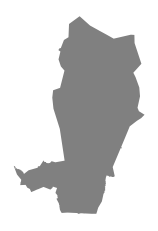

In [31]:
location_proj = ox.project_gdf(location_df)
ax = location_proj.plot(fc='gray', ec='none')
_ = ax.axis('off')

### Food sources

In [32]:
%%time
food_sources_tags = {
    "shop": [
        "supermarket",
        "convenience",
        "bakery",
    ]
}
food_sources_gdf = ox.pois_from_place(location, food_sources_tags)
food_sources_gdf.shape

CPU times: user 397 ms, sys: 12 ms, total: 409 ms
Wall time: 409 ms


(137, 54)

In [33]:
food_sources_gdf.head()

,osmid,geometry,amenity,element_type,shop,name,opening_hours,addr:city,addr:housenumber,addr:postcode,...,name:fi,name:sv,building:levels,roof:levels,takeaway:covid19,area,addr:housename,source:outline,mml:ref,description:covid19
33057409,33057409,POINT (23.60502 61.50775),retail,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33072615,33072615,POINT (23.62823 61.50601),NaN,node,bakery,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33403024,33403024,POINT (23.66238 61.50771),NaN,node,bakery,Jussinhannan Leipä Oy Kahvila-Myymälä,Mo-Fr 6:30-17:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33403046,33403046,POINT (23.68640 61.50778),NaN,node,convenience,K-Market Haapalinna,Mo-Su 7:00-23:00,Tampere,191,33270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59359661,59359661,POINT (23.78001 61.47957),NaN,node,supermarket,Nekalan Suurjako,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

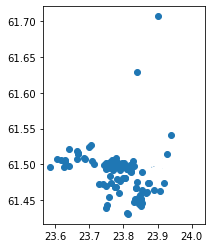

In [34]:
food_sources_gdf.plot()

### Bus stops

In [35]:
%%time
bus_stops_tags = {
    "amenity" : True,
    "highway" : "bus_stop"
}
bus_stops_gdf = ox.pois_from_place(location, bus_stops_tags)
bus_stops_gdf.shape

CPU times: user 9.29 s, sys: 44 ms, total: 9.34 s
Wall time: 9.33 s


(5026, 359)

<AxesSubplot:>

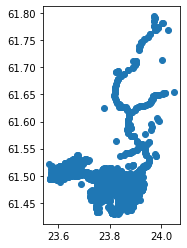

In [36]:
bus_stops_gdf.plot()

### Buildings

In [37]:
%%time
buildings_gdf = ox.footprints.footprints_from_place(location)
buildings_gdf.shape

CPU times: user 7.47 s, sys: 168 ms, total: 7.64 s
Wall time: 7.64 s


(40121, 212)

<AxesSubplot:>

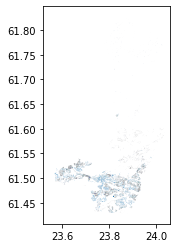

In [38]:
buildings_gdf.plot()

## Project the data

In [39]:
%%time
food_sources_gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 58.2 ms, sys: 3.99 ms, total: 62.2 ms
Wall time: 60.9 ms


In [40]:
%%time
bus_stops_gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 303 ms, sys: 4 ms, total: 307 ms
Wall time: 306 ms


In [41]:
%%time
buildings_gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.28 s


## Building centroids
Building geometries have varying numbers of points and lines, or complexity. We can simplify things by reducing each building footprint to the aproximate center, or centroid.

In [42]:
%%time
buildings_gdf["centroid"] = buildings_gdf["geometry"].centroid

CPU times: user 345 ms, sys: 0 ns, total: 345 ms
Wall time: 344 ms


In [43]:
buildings_gdf.head()

,nodes,building,name,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,cuisine,...,seamark:landmark:category,seamark:type,proposed,bicycle_parking,bell_tower,postal_code,members,type,historic:name,centroid
4881423,"[31577656, 3962324130, 3962324129, 3962324128,...",retail,Tesoman liikekeskus,"POLYGON ((2630290.258 8742900.292, 2630278.357...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2630225.788 8742972.055)
4881487,"[31579064, 31579065, 33057050, 33057069, 31579...",yes,Nokian Autogrilli Tesoma,"POLYGON ((2629091.135 8742698.292, 2629095.644...",Tampere,14,33310,Tesomankatu,fast_food,kebab,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629108.895 8742694.220)
4881551,"[31582436, 31582437, 31582438, 1139766076, 315...",retail,K-Market Winterinmutka,"POLYGON ((2634712.146 8743523.360, 2634786.396...",NaN,126,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2634757.358 8743507.709)
4900964,"[31927381, 1140935344, 1140935209, 31927396, 3...",school,Tesomajärven koulu,"POLYGON ((2629387.902 8743178.345, 2629367.430...",Tampere,7,33310,Raiskionkatu,school,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629435.841 8743196.911)
4983894,"[33051014, 33051011, 33051012, 33051013, 33051...",yes,NaN,"POLYGON ((2637171.795 8743326.127, 2637205.491...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2637191.237 8743327.620)


Since subsequent steps will work with a column called "geometry", we will swap our complicated footprints with the simple centroids by renaming columns.

In [44]:
buildings_gdf.rename(
    columns={
        "geometry": "footprint",
        "centroid": "geometry"
    }, 
    inplace=True
)

In [45]:
buildings_gdf.head()

,nodes,building,name,footprint,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,cuisine,...,seamark:landmark:category,seamark:type,proposed,bicycle_parking,bell_tower,postal_code,members,type,historic:name,geometry
4881423,"[31577656, 3962324130, 3962324129, 3962324128,...",retail,Tesoman liikekeskus,"POLYGON ((2630290.258 8742900.292, 2630278.357...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2630225.788 8742972.055)
4881487,"[31579064, 31579065, 33057050, 33057069, 31579...",yes,Nokian Autogrilli Tesoma,"POLYGON ((2629091.135 8742698.292, 2629095.644...",Tampere,14,33310,Tesomankatu,fast_food,kebab,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629108.895 8742694.220)
4881551,"[31582436, 31582437, 31582438, 1139766076, 315...",retail,K-Market Winterinmutka,"POLYGON ((2634712.146 8743523.360, 2634786.396...",NaN,126,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2634757.358 8743507.709)
4900964,"[31927381, 1140935344, 1140935209, 31927396, 3...",school,Tesomajärven koulu,"POLYGON ((2629387.902 8743178.345, 2629367.430...",Tampere,7,33310,Raiskionkatu,school,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629435.841 8743196.911)
4983894,"[33051014, 33051011, 33051012, 33051013, 33051...",yes,NaN,"POLYGON ((2637171.795 8743326.127, 2637205.491...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2637191.237 8743327.620)


Let's just double check that we still have two geometry columns.

In [46]:
buildings_gdf.dtypes

nodes              object
building           object
name               object
footprint        geometry
addr:city          object
                   ...   
postal_code        object
members            object
type               object
historic:name      object
geometry         geometry
Length: 213, dtype: object

## Create buffers
Next we will create "convenience" distances around each point in our data sets. Convenience is a hypothetical measure of how far people could reasonably access the amenities. These values are purely hypothetical, in order that we can work out further analysis below.

### Food sources

CPU times: user 150 ms, sys: 20 ms, total: 170 ms
Wall time: 109 ms


<AxesSubplot:>

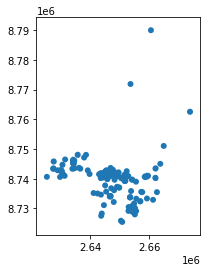

In [47]:
%%time
buffer_distance_m = 1000

food_sources_buffered = food_sources_gdf.buffer(buffer_distance_m)

food_sources_buffered.plot()

### Bus stops

CPU times: user 2.38 s, sys: 56 ms, total: 2.44 s
Wall time: 2.35 s


<AxesSubplot:>

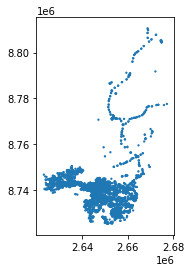

In [48]:
%%time
buffer_distance_m = 500

bus_stops_buffered = bus_stops_gdf.buffer(buffer_distance_m)

bus_stops_buffered.plot()

## Amenity catchments
Since the buffering step makes many separate and overlapping circles, we will combine the overlapping circles into larger "catchments".

### Food sources

In [50]:
%%time
food_sources_catchment = food_sources_buffered.unary_union

CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 137 ms


### Bus stops

In [52]:
%%time
bus_stops_catchment = bus_stops_buffered.unary_union

CPU times: user 5.73 s, sys: 0 ns, total: 5.73 s
Wall time: 5.73 s


## Access to amenities
Now we will combine the food and bus catchments for a composite measure of "access to amenities". We can combine arbitrarily many amenities here, but will start with the two previously mentioned.

Since we have boolean columns for each aminity catchment, we can simply check that each is `True` instead of using a geometrical intersection.

### Buildings within food catchment
Now we can search for buildings that are within the various catchments previously calculated.

In [54]:
%%time
buildings_gdf["within_food_catchment"] = buildings_gdf.within(food_sources_catchment)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


In [56]:
buildings_gdf["within_food_catchment"].value_counts(normalize=True)

False    0.568755
True     0.431245
Name: within_food_catchment, dtype: float64

### Buildings within bus catchment
Now we can search for buildings that are within the various catchments previously calculated. This step will likely take several minutes. You may want to get a cup of tea.

In [58]:
%%time
buildings_gdf["within_bus_catchment"] = buildings_gdf.within(bus_stops_catchment)

CPU times: user 7min 32s, sys: 132 ms, total: 7min 33s
Wall time: 7min 33s


### Composite analysis
Now we can combine the previously computed columns under a common indicator called "access to amenities". There can be arbitrarily many amenities, depending on what question is of interest.

In [59]:
def verify_access_to_amenities(row):
    """
    Make sure a given row has access to the desired aminities.
    """
    
    return (
        row["within_food_catchment"]
        and row["within_bus_catchment"]
    )

In [60]:
%%time
buildings_gdf["access_to_amenities"] = buildings_gdf.apply(verify_access_to_amenities, axis=1)

CPU times: user 438 ms, sys: 56 ms, total: 494 ms
Wall time: 494 ms


In [61]:
buildings_gdf["access_to_amenities"].value_counts(normalize=True)

False    0.588644
True     0.411356
Name: access_to_amenities, dtype: float64

### Visual representation
Let's take a look at the catchments to spot any differences.

In [62]:
colormap = ListedColormap(["coral", "forestgreen"])

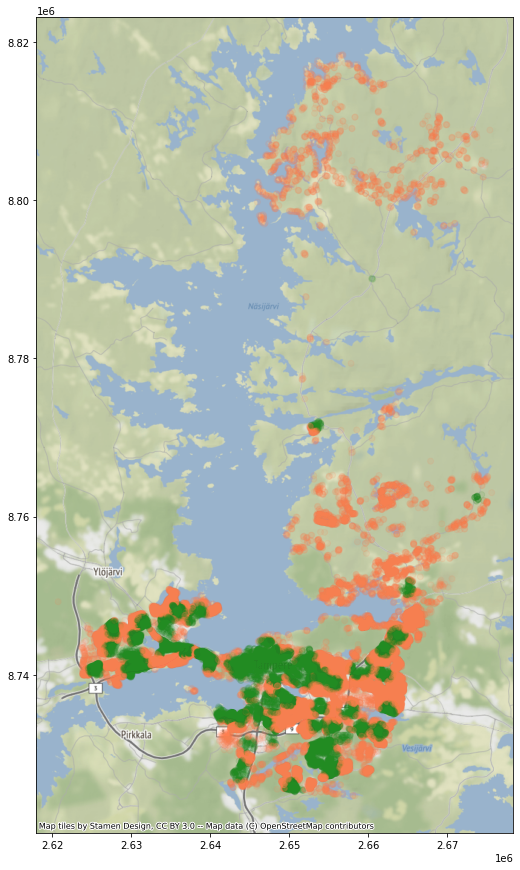

In [73]:
within_food_catchment_plot = buildings_gdf.plot(categorical=True, column="within_food_catchment", figsize=(20, 15), cmap=colormap, alpha=0.1)

contextily.add_basemap(within_food_catchment_plot)

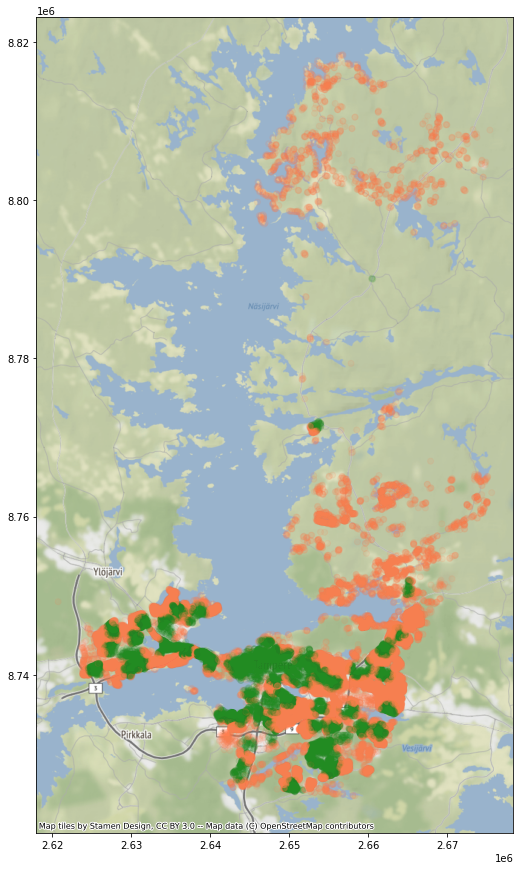

In [72]:
access_to_amenities_plot = buildings_gdf.plot(categorical=True, column="access_to_amenities",figsize=(20, 15), cmap=colormap, alpha=0.1)

contextily.add_basemap(access_to_amenities_plot)